# Firm Entry and Exit - Week 4 - OSE Lab
## Thomas Pellet
### 07/2019

## Question 1: Define a Recursive Equilibrium

As in Khan & Thomas (2009), it is possible to define a recursive equilibrium for the model. This equilibrium consists of four conditions:
* Firms maximize their value given households preferences (Stochastic discount factor pricing contingent claims). In other words, we have that
<p align="center">
$\frac{1}{1+r} = \beta \frac{C_{t+1}}{C_t} $
</p>
* The free entry condition holds, so that incumbent firms are at least indifferent between entering the market with zero capital or staying out. 
<p align="center">
$c_{e} \leq \int v(\varepsilon, 0) \nu(d \varepsilon)$
</p>
* The labor and goods market clears: 
<p align="center">
$N(z, g)=\int n(\varepsilon, k ; z, g) g(\varepsilon, k) d \varepsilon d k$
</p>
<p align="center">
$C(z, g)=\int y(\varepsilon, k ; z, g)  - i(\varepsilon, k ; z, g) d \varepsilon d k$
</p>
* The distribution of active firms $g^*(\epsilon,k)$ is stationary

## Question 2: Compute Representative Agent Steady State

In [1]:
from scipy.optimize import fsolve
import numpy as np

θ, ν, δ, β, ϕ, Nrep, Nϵ, cf = .21, .64, .1, 0.96, .5, .6, 10, 0.01
#Tauchen parameters
ρ,μ,σ =.9,0,.02


def steady_state_eqns(x, *args):
    Nrep, δ, β, θ, ν = args
    w = x[0]
    c = x[1]
    k = x[2]
    r = 1/β - (1 - δ)
    ret = np.zeros(3)
    ret[0] = r - θ* Nrep**ν * k**(θ-1)
    ret[1] = w - ν* Nrep**(ν-1) * k**(θ)
    ret[2] = c + k*δ - k**θ * Nrep**ν
    return ret

In [2]:
params = Nrep, δ, β, θ, ν
ss_vals = fsolve(steady_state_eqns, [.1,.3,.1], args=params) 
print("Steady State Wage: {}".format(ss_vals[0]))
print("Steady State Consumption: {}".format(ss_vals[1]))
print("Steady State Capital: {}".format(ss_vals[2]))
wrep = ss_vals[0]
Krep = ss_vals[2]

Steady State Wage: 0.7829715643836618
Steady State Consumption: 0.6252258227354607
Steady State Capital: 1.088100188742222


## Question 3: Solve for Incumbent Firms' Decision Rules

In [3]:
# Production function
def prod(ϵ, k, n):
    if k > 0:
        return np.exp(ϵ) * k**θ * n**ν
    else:
        return -50000000


# Wages
w_f     = lambda ϵ, k, n: ν * np.exp(ϵ) * k**θ * n**(ν-1)

# Labor supply
n_f       = lambda ϵ, k, w: (w / (ν * np.exp(ϵ) * k**θ ))**(1/(ν-1))

# Interest rate
r_f     = lambda ϵ, k, n: θ * np.exp(ϵ) * k**(θ-1) * n**ν

# Profits
Π     = lambda y, kp, k, n, w: y - w*n - (kp - (1 - δ)*k) - 0.5*ϕ * \
        (kp/k - (1-δ))**2*k



# Utility function
def Uprime(c):
    if c > 0:
        return 1/c
    else:
        return 50000000




In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 20
tol, epsi, maxiter =1e-6,1, 1000
Nϵ = 5
### State space K
Kmin=0.1
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span


# ##interpolation function that returns function handle given interp type
# def interpolate(k_grid, policy, method="pw-linear", ndegree=None, A=None ):
#     if method == "pw-linear":
#         t = interpol.interp1d(k_grid, policy, kind='linear',fill_value="extrapolate")
            
#     elif method == "chebyshev":
#         ###Get chebyshev coefficients 
#         coeff = chebyshev.chebfit(k_grid, policy, ndegree)
#         t = lambda x: chebyshev.chebval(x, coeff)

#     elif method == "cubic-spline":
#         t = interpol.interp1d(k_grid, policy, kind='cubic',fill_value="extrapolate")
        
#     else: raise NameError("invalid choice of interpolation method. Valid methods are \
#                            'pw-linear,' 'chebyshev,' 'cubic-spline,' or 'ar_1'")
#     return t



# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(x, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(x,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, x, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff


iter= 0
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    print("Number of iterations: ", iter)

    for j in range(sizeK):

        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            params = Kgrid, Vp, j, l, A, P, wrep, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
            solve = minimize(Bellman,Kp[j,l], args = params)
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun
            if exit[j,l] == 1:
                 Kp_new[j,l] = 0

    epsi = ((Vp_new - Vp) ** 2).sum()
    print("Error term: ", epsi)
    if epsi < tol:
        break
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1








Number of iterations:  0
Error term:  417.97710526315797
Number of iterations:  1
Error term:  1.3136826352966668
Number of iterations:  2
Error term:  1.5338221578586995
Number of iterations:  3
Error term:  2.900088088378104
Number of iterations:  4
Error term:  3.957121935040613
Number of iterations:  5
Error term:  3.0822590900346847
Number of iterations:  6
Error term:  4.408436135104032
Number of iterations:  7
Error term:  4.546495976978192
Number of iterations:  8
Error term:  4.213669830643316
Number of iterations:  9
Error term:  3.3706229772417156
Number of iterations:  10
Error term:  3.0103334790466456
Number of iterations:  11
Error term:  2.4597186711743824
Number of iterations:  12
Error term:  1.0768233408773544
Number of iterations:  13
Error term:  1.8108929920137948
Number of iterations:  14
Error term:  0.38247625076740643
Number of iterations:  15
Error term:  0.3505663505784408
Number of iterations:  16
Error term:  0.3217041857369889
Number of iterations:  17
Er

Error term:  1.7609276237634167e-05
Number of iterations:  137
Error term:  1.622870898060337e-05
Number of iterations:  138
Error term:  1.4956378196513967e-05
Number of iterations:  139
Error term:  1.3783798145921125e-05
Number of iterations:  140
Error term:  1.2703148371272418e-05
Number of iterations:  141
Error term:  1.1707221538967148e-05
Number of iterations:  142
Error term:  1.0789375370317406e-05
Number of iterations:  143
Error term:  9.9434883412765e-06
Number of iterations:  144
Error term:  9.163918855316353e-06
Number of iterations:  145
Error term:  8.44546761706402e-06
Number of iterations:  146
Error term:  7.783342955892118e-06
Number of iterations:  147
Error term:  7.173128868139242e-06
Number of iterations:  148
Error term:  6.6107555648873115e-06
Number of iterations:  149
Error term:  6.092472328583246e-06
Number of iterations:  150
Error term:  5.614822498027489e-06
Number of iterations:  151
Error term:  5.1746204141877916e-06
Number of iterations:  152
Err

<function matplotlib.pyplot.show(*args, **kw)>

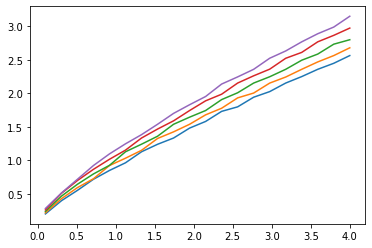

In [5]:
for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

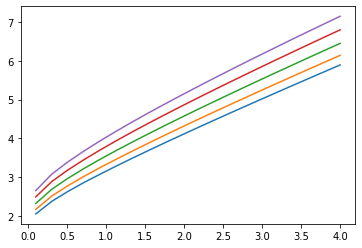

In [6]:
for i in range(Nϵ):
    plt.plot(Kgrid, Vp[:,i])

plt.show

### Question 4: Compute the market-clearing wage

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.optimize import root
from matplotlib import pyplot as plt
import tauchen

Nϵ = 5
sizeK = 10
tol, epsi, maxiter =1e-3,1, 1000

### State space K
Kmin=0.2
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)

# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(kp, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(kp,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, kp, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff
    
    
    
def Bellman_new(kp, Vp, Kgrid, P, l, Nϵ):

    exp=np.zeros(np.int_(Nϵ)) # Dimension of exp is dimension of A, number of shocks

    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(kp,Kgrid,Vp[:,i])
        
    value = - kp + np.sum(exp)
    return - value
            



#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])


def get_wage(x,*args):
    Vp, Kp, sizeK, Nϵ, Ce, Krep, A, P, distribution = args
    iter= 0
    Vp=Kmin*np.ones([sizeK,Nϵ])
    Kp=Krep*np.ones([sizeK,Nϵ])
    exit =np.zeros([sizeK,Nϵ])
    Vp_new=np.zeros([sizeK,Nϵ])
    Kp_new=np.zeros([sizeK,Nϵ])
    print("Guess for W is: ", x)
    while iter < maxiter:

        #print("Number of iterations: ", iter)

        for j in range(sizeK):

            for l in range(Nϵ):
    #             print('Random shock number ', l)
                # Make the value function dependent on future K only
                params = Kgrid, Vp, j, l, A, P, x, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
                solve = minimize(Bellman,Kp[j,l], args = params)
                Kp_new[j,l] = solve.x
                Vp_new[j,l] = - solve.fun
                if exit[j,l] == 1:
                     Kp_new[j,l] = 0
                


        epsi = ((Vp_new - Vp) ** 2).sum()
#         print("Error term: ", epsi)
        if epsi < tol:
            break
        #Update
        Kp=Kp_new*1.
        Vp = Vp_new*1.
        iter=iter+1

    # compute the value function of new entrants
    Vhat = Vp[0,:]
    for l in range(Nϵ):
        Bellman_new_x = lambda x: Bellman_new(x, Vp, Kgrid, P, l, Nϵ)
        solve = minimize(Bellman_new_x, Krep)
        Vhat[l] = - solve.fun

    integral = np.dot(distribution, Vhat)*ν

    clearing = Ce - integral
    print(clearing)

    return clearing




In [8]:
Ce = 0.1
#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
params = Vp, Kp, sizeK, Nϵ, Ce, Krep, A, P, distribution
wage = fsolve(get_wage, 0.8, args = params)



Guess for W is:  [0.8]
-1.229701022287178
Guess for W is:  [0.8]
-1.229701022287178
Guess for W is:  [0.8]
-1.229701022287178
Guess for W is:  [0.80000001]
-1.2297009276145305
Guess for W is:  [0.95484069]
-2.0074692816543285e+36
Guess for W is:  [0.8]
-1.229701022287178


In [9]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.optimize import root
from matplotlib import pyplot as plt
import tauchen

Nϵ = 5
sizeK = 10
tol, epsi, maxiter =1e-3,1, 1000

### State space K
Kmin=0.2
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)

# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(kp, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(kp,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, kp, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff
    
    
    
def Bellman_new(kp, Vp, Kgrid, P, l, Nϵ):

    exp=np.zeros(np.int_(Nϵ)) # Dimension of exp is dimension of A, number of shocks

    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(kp,Kgrid,Vp[:,i])
        
    value = - kp + np.sum(exp)
    return - value
            



#Vp=Kmin*np.ones([sizeK,Nϵ])
#Kp=Krep*np.ones([sizeK,Nϵ])
W = np.linspace(0.8,1,10)
clearing = np.zeros_like(W)
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])

Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

for i,item in enumerate(W):
    print("Guess for W is: ", item)

    iter= 0


    while iter < maxiter:

        #print("Number of iterations: ", iter)

        for j in range(sizeK):

            for l in range(Nϵ):
    #             print('Random shock number ', l)
                # Make the value function dependent on future K only
                params = Kgrid, Vp, j, l, A, P, item, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
                solve = minimize(Bellman,Kp[j,l], args = params)
                Kp_new[j,l] = solve.x
                Vp_new[j,l] = - solve.fun
                if exit[j,l] == 1:
                     Kp_new[j,l] = 0


        epsi = ((Vp_new - Vp) ** 2).sum()
#         print("Error term: ", epsi)
        if epsi < tol:
            break
        #Update
        Kp=Kp_new*1.
        Vp = Vp_new*1.
        iter=iter+1

    # compute the value function of new entrants
    Vhat = Vp[0,:]
    for l in range(Nϵ):
        Bellman_new_x = lambda x: Bellman_new(x, Vp, Kgrid, P, l, Nϵ)
        solve = minimize(Bellman_new_x, Krep)
        Vhat[l] = - solve.fun

    integral = np.dot(distribution, Vhat)*ν

    clearing[i] = Ce - integral
    print(clearing[i])





Guess for W is:  0.8
-1.229701022287178
Guess for W is:  0.8222222222222223
-1.187265714596333
Guess for W is:  0.8444444444444444
-1.0415175928290559
Guess for W is:  0.8666666666666667
-0.9117227512589442
Guess for W is:  0.888888888888889
-0.7981688571784179
Guess for W is:  0.9111111111111111
-0.6966231405209591
Guess for W is:  0.9333333333333333
-0.6021070306214313
Guess for W is:  0.9555555555555555
-0.5139497547236695
Guess for W is:  0.9777777777777777
-1.0598426225655004e+36
Guess for W is:  1.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in add
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufun

/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:392: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs

/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:392: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: overflow encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/l

KeyboardInterrupt: 

### Question 5: Solving for the static distribution of firms and the mass of firms

#### Get the value function at the optimal wage


In [10]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 10
tol, epsi, maxiter =1e-5,1, 1000
Nϵ = 5
### State space K
Kmin=0.1
Kmax=4
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span

wrep = 0.955

iterate = 100000
distribution = np.ones_like(A)/len(A)
for i in range(iterate):
    distribution = np.dot(distribution,P)


# ##interpolation function that returns function handle given interp type
# def interpolate(k_grid, policy, method="pw-linear", ndegree=None, A=None ):
#     if method == "pw-linear":
#         t = interpol.interp1d(k_grid, policy, kind='linear',fill_value="extrapolate")
            
#     elif method == "chebyshev":
#         ###Get chebyshev coefficients 
#         coeff = chebyshev.chebfit(k_grid, policy, ndegree)
#         t = lambda x: chebyshev.chebval(x, coeff)

#     elif method == "cubic-spline":
#         t = interpol.interp1d(k_grid, policy, kind='cubic',fill_value="extrapolate")
        
#     else: raise NameError("invalid choice of interpolation method. Valid methods are \
#                            'pw-linear,' 'chebyshev,' 'cubic-spline,' or 'ar_1'")
#     return t



# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t = interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def Bellman(x, *params):
    Kgrid, Vp, j, l, A, P, W, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π = params
        
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] =  P[l,i]*interpolant(x,Kgrid,Vp[:,i])  
    FutureVal = β * np.sum(exp)  
    
    N         = n_f(A[l], Kgrid[j], W)
    Y         = prod(A[l], Kgrid[j], N)
    R         = r_f(A[l], Kgrid[j], N)
    profit    = Π(Y, x, Kgrid[j], N, W)
    V         = profit + FutureVal
    
    exitpayoff = (1-δ)*Kgrid[j]
    staypayoff = V - cf
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        exit[j,l] = 0
        return -staypayoff


iter= 0
Vp=Kmin*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    print("Number of iterations: ", iter)

    for j in range(sizeK):

        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            params = Kgrid, Vp, j, l, A, P, wrep, Nϵ, cf, exit, interpolant, n_f, prod, r_f, Π
            solve = minimize(Bellman,Kp[j,l], args = params)
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun
            if exit[j,l] == 1:
                 Kp_new[j,l] = 0

    epsi = ((Vp_new - Vp) ** 2).sum()
    print("Error term: ", epsi)
    if epsi < tol:
        break
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1






Number of iterations:  0
Error term:  214.9925
Number of iterations:  1
Error term:  0.03392358233856508
Number of iterations:  2
Error term:  0.08856249412293439
Number of iterations:  3
Error term:  0.055109851462272985
Number of iterations:  4
Error term:  0.23632281370284666
Number of iterations:  5
Error term:  0.05440056536433716
Number of iterations:  6
Error term:  0.4927985697431585
Number of iterations:  7
Error term:  0.05108181274568326
Number of iterations:  8
Error term:  0.021031191405586416
Number of iterations:  9
Error term:  0.7744881946131066
Number of iterations:  10
Error term:  0.18379277795206422
Number of iterations:  11
Error term:  0.5388845603246295
Number of iterations:  12
Error term:  0.4391158416594099
Number of iterations:  13
Error term:  0.37383865229954816
Number of iterations:  14
Error term:  0.6661851874377848
Number of iterations:  15
Error term:  0.4543573542614396
Number of iterations:  16
Error term:  0.7332425536470469
Number of iterations:  

<function matplotlib.pyplot.show(*args, **kw)>

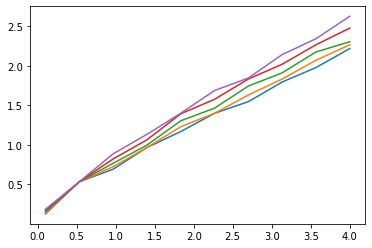

In [11]:
for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])

plt.show

In [12]:
Stay = exit*(-1) + 1
Stay = Stay.flatten()
print(Stay)
test = np.tile(Kgrid, Nϵ)
print(test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0.1        0.53333333 0.96666667 1.4        1.83333333 2.26666667
 2.7        3.13333333 3.56666667 4.         0.1        0.53333333
 0.96666667 1.4        1.83333333 2.26666667 2.7        3.13333333
 3.56666667 4.         0.1        0.53333333 0.96666667 1.4
 1.83333333 2.26666667 2.7        3.13333333 3.56666667 4.
 0.1        0.53333333 0.96666667 1.4        1.83333333 2.26666667
 2.7        3.13333333 3.56666667 4.         0.1        0.53333333
 0.96666667 1.4        1.83333333 2.26666667 2.7        3.13333333
 3.56666667 4.        ]


In [296]:
# Guess for the distribution of firms across capital and productivity states
Stay = exit*(-1) + 1
Stay = np.tile(Stay,(Nϵ,sizeK))
print("Dimensions of Stay matrix", Stay.shape)
#stack Kgrid Nϵ times 
K = np.repeat(Kgrid, Nϵ)
print("Dimensions of K", K.shape)


#Expand the transition matrix for the markov process
Πϵ = np.tile(P,(sizeK, sizeK))
print("Dimensions of Markov process", Πϵ.shape)

# Flatten Kprime
Kprime = np.tile(Kp,(Nϵ,sizeK))
print("Dimensions of Kprime process", Kprime.shape)
Πk = np.zeros_like(Πϵ)

# Compute mass of points at each K'

for i,item in enumerate(K):
    Πk[i] = np.sum(np.abs(Kprime - K[i]) < np.abs(K[0] - K[1]))/len(K)
    print(Πk[i])
    
print(Πk)
print("Dimensions of Pi k process", Πk.shape)

G = np.ones(Nϵ*sizeK)/(Nϵ*sizeK)

#Distribution of nu
D = np.tile(distribution,sizeK)

T = Πϵ*Πk*Stay
m = 1
for i in range(1000):
    G = np.dot(G,T) + m*D

print("Final distribution: ", G)
# Simulate over the policy function for K 


Dimensions of Stay matrix (50, 50)
Dimensions of K (50,)
Dimensions of Markov process (50, 50)
Dimensions of Kprime process (50, 50)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [297]:
np.sum(G)


9.999999999999966

In [298]:
Gmatrix = G.reshape((sizeK,Nϵ))
print(G)
print(Gmatrix)

[0.08381483 0.24294585 0.34647865 0.24294585 0.08381483 0.08381483
 0.24294585 0.34647865 0.24294585 0.08381483 0.08381483 0.24294585
 0.34647865 0.24294585 0.08381483 0.08381483 0.24294585 0.34647865
 0.24294585 0.08381483 0.08381483 0.24294585 0.34647865 0.24294585
 0.08381483 0.08381483 0.24294585 0.34647865 0.24294585 0.08381483
 0.08381483 0.24294585 0.34647865 0.24294585 0.08381483 0.08381483
 0.24294585 0.34647865 0.24294585 0.08381483 0.08381483 0.24294585
 0.34647865 0.24294585 0.08381483 0.08381483 0.24294585 0.34647865
 0.24294585 0.08381483]
[[0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865 0.24294585 0.08381483]
 [0.08381483 0.24294585 0.34647865

<function matplotlib.pyplot.show(*args, **kw)>

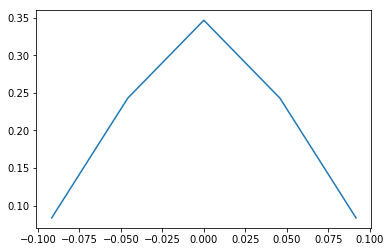

In [299]:
plt.plot(A[0:Nϵ], G[0:Nϵ])
plt.show

In [ ]:
plt.plot(Kgrid[0:Nϵ], G[0:Nϵ])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

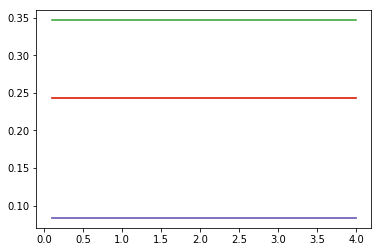

In [300]:
for i in range(Nϵ):
    plt.plot(Kgrid, Gmatrix[:,i])
    
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

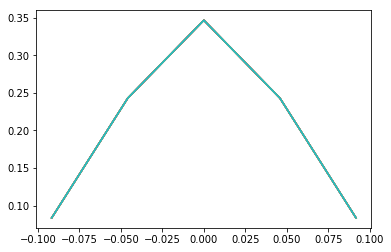

In [301]:
for i in range(sizeK):
    plt.plot(A, Gmatrix[i,:])
plt.show